### Numpy 加速
Python 是一种相对较慢的编程语言，但是我们可以通过使用Numpy来加速Python的运算。Numpy是一个基于C语言的库，提供了许多高效的运算函数，例如矩阵运算和线性代数运算等。这些运算都基于C语言实现，因此速度非常快。

GP的性能瓶颈通常在于模型评估。因此，在这里，我们重点关注如何加速评估函数。其实很简单，将数据集转换为Numpy数组，然后使用Numpy函数来计算MSE即可。下面是一个例子。

In [1]:
import time

import numpy as np
from deap import base, creator, tools, gp


# 符号回归
def evalSymbReg(individual, pset):
    # 编译GP树为函数
    func = gp.compile(expr=individual, pset=pset)
    
    # 使用numpy创建一个向量
    x = np.linspace(-10, 10, 100) 
    
    # 评估生成的函数并计算MSE
    mse = np.mean((func(x) - x**2)**2)
    
    return (mse,)

# 创建个体和适应度函数
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)


同时，我们还可以考虑将一些算子替换为Numpy函数。尽管这并不是非常重要，因为Numpy已经重载了许多运算符。

In [2]:
import random

# 定义函数集合和终端集合
pset = gp.PrimitiveSet("MAIN", arity=1)
pset.addPrimitive(np.add, 2)
pset.addPrimitive(np.subtract, 2)
pset.addPrimitive(np.multiply, 2)
pset.addPrimitive(np.negative, 1)
def random_int(): return random.randint(-1, 1)
pset.addEphemeralConstant("rand101", random_int)
pset.renameArguments(ARG0='x')

# 定义遗传编程操作
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", evalSymbReg, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)

现在，让我们来测试一下加速效果。

In [3]:
import numpy
from deap import algorithms

# 定义统计指标
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

# 使用默认算法
np_time=[]
for i in range(3):
    start=time.time()
    population = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    pop, log  = algorithms.eaSimple(population=population,
                               toolbox=toolbox, cxpb=0.9, mutpb=0.1, ngen=10, stats=mstats, halloffame=hof, verbose=True)
    end=time.time()
    print('time:',end-start)
    np_time.append(end-start)
    print(str(hof[0]))

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max   	min	nevals	std    	avg    	gen	max	min	nevals	std    
0  	300   	3231.36	0  	153712	0  	300   	12338.5	3.90333	0  	7  	2  	300   	1.61884
1  	266   	2585.69	1  	153712	0  	266   	8907.64	4      	1  	11 	2  	266   	1.82392
2  	278   	3919.23	2  	159956	0  	278   	17641.7	4.21   	2  	11 	2  	278   	1.74907
3  	265   	43227.2	3  	1.23323e+07	0  	265   	710749 	4.31667	3  	12 	2  	265   	1.88053
4  	273   	3408.05	4  	153712     	0  	273   	17494.5	4.15   	4  	13 	2  	273   	1.77036
5  	264   	5199.33	5  	157978     	0  	264   	24605.9	4.08667	5  	13 	3  	264   	1.82185
6  	280   	45092.2	6  	1.23323e+07	0  	280   	710911 	3.67333	6  	13 	3  	280   	1.46514
7  	277   	1893.94	7  	153712     	0  	277   	15176.7	3.32   	7  	13 	3  	277   	1.09739
8  	2

对比下面的原始评估函数，使用Numpy的加速效果还是非常明显的。

In [4]:
# 慢速评估
def evalSymbRegSlow(individual, pset):
    # 编译GP树为函数
    func = gp.compile(expr=individual, pset=pset)
    
    # 创建评估数据
    xs = [x/5.0 for x in range(-50, 51)]
    
    # 评估生成的函数并计算MSE
    mse = sum((func(x) - x**2)**2 for x in xs) / len(xs)
    
    return (mse,)

toolbox.register("evaluate", evalSymbRegSlow, pset=pset)

py_time=[]
for i in range(3):
    start=time.time()
    population = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    pop, log  = algorithms.eaSimple(population=population,
                               toolbox=toolbox, cxpb=0.9, mutpb=0.1, ngen=10, stats=mstats, halloffame=hof, verbose=True)
    end=time.time()
    print('time:',end-start)
    py_time.append(end-start)

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max   	min	nevals	std    	avg    	gen	max	min	nevals	std    
0  	300   	5101.77	0  	608247	0  	300   	37075.7	4.11667	0  	7  	2  	300   	1.67821
1  	278   	3934.9 	1  	157817	0  	278   	17563.9	4.62333	1  	13 	2  	278   	1.94802
2  	282   	3837.35	2  	153622	0  	282   	17495.9	5.05667	2  	14 	2  	282   	2.17718
3  	269   	48570.9	3  	1.17166e+07	0  	269   	676326 	5.36333	3  	14 	2  	269   	2.32049
4  	267   	8871.01	4  	157817     	0  	267   	33190.2	5.77   	4  	15 	2  	267   	2.52529
5  	280   	8154.67	5  	153622     	0  	280   	32084.7	5.89667	5  	19 	2  	280   	2.54676
6  	267   	45572.2	6  	1.17166e+07	0  	267   	675571 	5.97   	6  	17 	2  	267   	2.68125
7  	275   	48064.9	7  	1.23228e+07	0  	275   	710493 	6.15333	7  	17 	2  	275   	2.63119
8  	2

最后，我们可以使用seaborn绘制一个图来比较Numpy和Python的性能。可以看出，Numpy显著提高了速度。

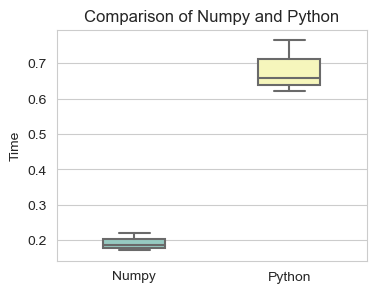

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
data = pd.DataFrame({'Category': ['Numpy'] * len(np_time) + ['Python'] * len(py_time),
                     'Time': np.concatenate([np_time, py_time])})


plt.figure(figsize=(4, 3))
sns.set_style("whitegrid")
sns.boxplot(data=data, x='Category', y='Time',palette="Set3", width=0.4)
plt.title('Comparison of Numpy and Python')
plt.xlabel('')
plt.ylabel('Time')
plt.show()